In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Math Concepts for Developers
## Exercise: High-school maths
### Problem 9: Perlin Noise
### Solution by: Lyubomir Tankishev

In this notebook I will show my solution for generating 2D Perlin Noise.

#### Contents
1. [What is Perlin Noise?](#what_is)
2. [How does it work?](#how_does_it_work)
3. [Solution](#my_solution)
    1. [Defining the grid](#gen_the_grids)
    2. [Generating the gradient vectors](#gen_gradient_vectors)
    3. [Generating the distance matrix for the distance vectors](#gen_distance_vectors)
    4. [Calculation of the dot products and gradient values](#calculate_gradient)
4. [Putting it all together](#perlin_noise)
5. [Playing around with the code](#lets_play)
6. Next steps

<a id='what_is'></a>
#### 1. What is Perlin Noise

If you are interested in the detailed definition, you can find a lot of detailed information on the internet. That said, in simple terms, Perlin Noise is an algorithm for generation of pseudo random noise with a more organic look & feel to it. This algorithm was created by Ken Perlin in the 1980s to solve the challenge of generating textures with computer algorithm that have a natural look to them. Such procedural generation of textures was needed for the increasing use of computer generated images in the movie industry. Later it was heavily adopted by the computer games as well. 

To understand better the context lets first create a 2D fully random image.

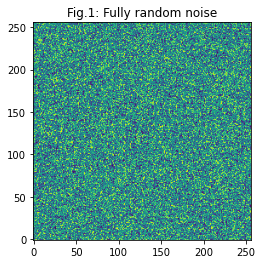

In [3]:
def fully_random_generation(size):
    arr = np.random.rand(size ** 2)
    arr = arr.reshape([size, size])
    plt.imshow(arr)
    plt.gca().invert_yaxis()
    plt.title("Fig.1: Fully random noise")
    plt.show()
    
fully_random_generation(256)

Now, lets compare the image above with the next one which is generated using the 2D Perlin Noise algorithm that is described in this book. One can easily notice that although there is randomness in the image it is much more natural looking.

<p style="text-align: left;"><b>Fig.2:</b> Perlin Noise</p>
<img src="perlin_noise.png" width="256" height="256" align="left"/>

<a id='how_does_it_work'></a>
#### 2. How does it work?
The 2D Perlin Noise algorithm works by computing the a value for each pixel (cell) in an image (grid of pixels) as a function of the pixels location and a set of gradient vectors. The image is broken down to sub grids and a gradient vector is assigned to the corner of each sub grid. Each sub grid contains a number of pixels. The smaller the grid, the higher the granularity in the final image. Setting a sub grid of 1 pixel will ultimately generate a result similar to random noise. 

<img src="https://upload.wikimedia.org/wikipedia/commons/0/09/PerlinNoiseGradientGrid.png" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.3:</b>Grid and random gradient vectors <a href="https://en.wikipedia.org/wiki/Perlin_noise">(source)</a></p>

After that the the dot product of the applicable gradient vectors and the distance vectors of that pixel to the corners of the sub grid are computed.

<img src="https://codelirium.com/public/images/perlin-noise/perlin-algo-1.png" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.4:</b>Gradient and distance vectors <a href="https://codelirium.com/article/perlin-noise">(source)</a></p>

Finaly the resulting dot products are interpolated to get the resulting gradient value of the selected pixel. This process is repeated for each pixel in the image to generate the final result.

<img src="https://codelirium.com/public/images/perlin-noise/perlin-algo-2.png
" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.5:</b>Interpolation of dot products <a href="https://codelirium.com/article/perlin-noise">(source)</a></p>

This process is then repeated for each pixel in the image to generate the final result.


<a id='my_solution'></a>
#### 3. Solution
Now that we know the basics lets try to recreate the algorithm. But first, its disclaimer time :-)
<br>DISCLAMER: Although I understand the concept, my algorithm is likely going to be inefficient and probably can be written much better. Also, there might be some deviations due to uncertainty how to implement some parts of the algorithm.

Pfff..., after I got this off my chest, let's start.

My personal preference is to code in sections defining several functions each implementing a step from the final code.

<a id='gen_the_grids'></a>
<u>A. Defining the grids</u><br>
We start with generating the main grid and splitting it in gradient vector sub grid.

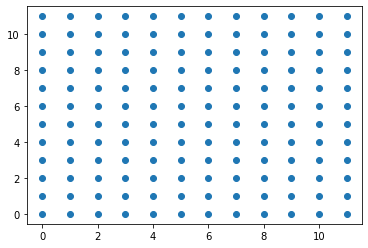

In [4]:
# First we will generate the main grid
def gen_main_grid(grid_size: int) -> tuple:
    """
    The function returns a tuple of arrays with coordinates for each pixel 
    """
    side = np.arange(0, grid_size, 1)
    x_axis = np.tile(side, grid_size)
    y_axis = np.repeat(side, grid_size)
    return x_axis, y_axis

# Test: plotting the output
main_grid_size = 12

x, y = gen_main_grid(main_grid_size)
plt.scatter(x, y, marker='o')
plt.show()

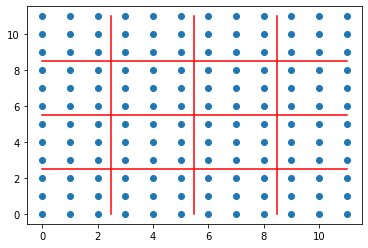

In [5]:
# Next we will select the gradient vectors grid size. 
# The smaller the number of pixels in each subgrid the the higher the granularity in the final output.

def gen_grad_grid(main_grid_size: int, granularity=1) -> tuple:
    """
    This fucnction makes sure that the main grid size can be split to the chosen granularity 
    """
    while main_grid_size % granularity != 0:
        granularity -= 1
    grad_grid_size = int(main_grid_size / granularity)
    return granularity, grad_grid_size

# Test: Let's plot it
main_grid_size = 12
granularity = 3

x, y = gen_main_grid(main_grid_size)
plt.scatter(x, y, marker='o')
g, g_size = gen_grad_grid(main_grid_size, granularity)
line = np.linspace(0, main_grid_size - 1, 1000)
for i in range(0, g):
    data = np.full(1000, g*(i+1) - 0.5)
    plt.plot(line, data, 'r')
    plt.plot(data, line, 'r')
plt.show()


<a id='gen_gradient_vectors'></a>
<u>B. Generating the gradient vectors</u><br>
Next we will generate our gradient vectors. For purpose we will first create a tuple of possible vectors. After that we will randomly select the number of vectors that we need in accordance with the size of our gradient sub grid. <br>

The usual implementation of Perlin Noise uses the following set of four or eight vectors:<br>
$\big\{(1, 1), (-1, 1), (1, -1), (-1, -1)\big\}$; or<br>
$\big\{(1, 1), (-1, 1), (1, -1), (-1, -1), (\sqrt{2}, 0), (0, \sqrt{2}), (-\sqrt{2}, 0), (0, -\sqrt{2})\big\}$<br>

That said i wanted to create I wanted to define my own vectors that are equally spaced in a circle with a radius of $1$ and having values between $-1$ and $1$. Using numpy.linspace we can easily achieve that.
```python
v = np.linspace(0, 2 * np.pi, number_of_unique_vectors + 1)
vx = np.round(np.cos(v), 5)
vy = np.round(np.sin(v), 5)
vectors = tuple(zip(vx, vy))
```
The `+ 1` in the first line is added because $\sin 0$ and $\sin 2\pi$ are the same (similary for $\cos x$). All that is left then is to randomly select a number of vectors for our grid.

In [6]:
def generate_gradient_vectors_matrix(number_of_unique_vectors: int, gradient_grid_size: int) -> np.ndarray:

    v = np.linspace(0, 2 * np.pi, number_of_unique_vectors + 1)
    vy = np.round(np.sin(v), 5)
    vx = np.round(np.cos(v), 5)
    vectors = tuple(zip(vx, vy))
    
    vector_indexes = list(range(number_of_unique_vectors))
    random_indexes = np.random.choice(vector_indexes, size=gradient_grid_size**2)
    
    return np.array([vectors[idx] for idx in random_indexes]).reshape([gradient_grid_size, gradient_grid_size, 2])

# Test: Generating 8 unique vectors and selecting 9 (for a grid of 3x3) for our gradient vector matrix (gmv)
# Run the cell couple of times to see how the chosen vectors change.

gvm = generate_gradient_vectors_matrix(8 , 9)
print(gvm[0])

# print(gvm)

[[ 0.       1.     ]
 [ 0.       1.     ]
 [-0.70711 -0.70711]
 [-0.      -1.     ]
 [-0.70711 -0.70711]
 [ 0.70711 -0.70711]
 [ 0.70711  0.70711]
 [-0.      -1.     ]
 [ 0.70711 -0.70711]]


<a id='gen_distance_vectors'></a>
<u>C. Generating the distance matrix for the distance vectors</u><br>
In order to generate the distance vectors it will be helpful to create a matrix with the relative distance of each pixel from the gradient vectors that surround it. For that purpose we first need to find the relative index of that pixel and assign a distance value to it for both the $x$ and $y$ coordinates.

We generate the matrix only once as it is applicable for all pixels.
```python
dm = np.linspace(0, 1, grad_grid_size)
```
An then in the *calculate_gradient* fuction we will use it multiple times to get the distance to each corner of the gradient vector grid.
```python
# Calc the relative location of the cell in the dm
xloc, yloc = x % len(dm), y % len(dm)

# Calc the distance vectors (bottom left, bottom right, top left, top right)
dbl = np.array([dm[xloc], dm[yloc]])
dbr = np.array([dm[xloc] - 1, dm[yloc]])
dtl = np.array([dm[xloc], dm[yloc] - 1])
dtr = np.array([dm[xloc] - 1, dm[yloc] - 1])
```

<a id='calculate_gradient'></a>
<u>D. Calculation of the dot products and gradient values</u><br>
Now comes the part where we will compute the gradient values for each pixel. This is done in four steps:
* Find the relative position of the pixel in the gradient sub grid (see above);
* Calculate the distance vector to that position (see above);
* Get the correct gradient vectors from the precomputed set;
* Calculate the dot product of the gradient vectors and distance vectors; and
* Interpolate the results

We will pass to our function the coordinates of the `bottom left` gradient vector (`gvc`) and relative to that one, extract the `other three` vectors from the gradient vector matrix (`gvm`).
```python
gbl = gvm[gvc[0]][gvc[1]]
gbr = gvm[gvc[0] + 1][gvc[1]]
gtl = gvm[gvc[0]][gvc[1] + 1]
gtr = gvm[gvc[0] + 1][gvc[1] + 1]
```

Once we have done that we use the `numpy.dot` built in function to calculate the dot products of the vectors (where `_x` is the respective corner of the gradient sub grid.
```python
dp_x = np.dot(db_x, gb_x)
```

Finaly, we need to interpolate the results to get the gradient value of the pixel. To do that we will use the following equations (where $t_{x}$ is the relative position of the pixel on the x-axis and $t_{y}$ is the relative position of the pixel on the y-axis; we can get both from the `dm` matrix): 

$$l_{0}=d_{00}+t_{x}*(d_{01}-d_{00})$$
$$l_{1}=d_{10}+t_{x}*(d_{11}-d_{10})$$
$$gradient=l_{0}+t_{y}*(l_{1}-l_{0})$$

We can use linear interpolation, but the Perlin Noise algorithm uses a S-curve one for better results. For this algorithm we will use the same fade function, namely:
$$6t^5-15t^4+10t^3$$

In [7]:
# Defining our smoothing function
def fade_noise(x):
    return x**5 * 6 - x**4 * 15 + x**3 * 10

In [8]:
# Taking all of the above into account we get the following function for calulation of the gradent value:

def calc_gradient(x: int, y: int, dm: np.ndarray, gvc: np.ndarray, gvm: list):
    """
    This fucntion calculates the gradient value for a given pixel (cell).
    
    Args:
        x, y (int): the x and y coordinates of the cell in the main grid
        dm (numpy.ndarray): an array with the relative distance matrix for the gradient grid
        gvc (numpy.ndarray): an array with the coordinates of the lower left gradient vector for this pixel
        gvm (list): the matrix with gradient distance vectors
    """
    
    # Calc the relative location of the cell in the dm
    xloc, yloc = x % len(dm), y % len(dm)

    # Calc the distance vectors (bottom left, bottom right, top left, top right)
    dbl = np.array([dm[xloc], dm[yloc]])
    dbr = np.array([dm[xloc] - 1, dm[yloc]])
    dtl = np.array([dm[xloc], dm[yloc] - 1])
    dtr = np.array([dm[xloc] - 1, dm[yloc] - 1])

    # Get the gradient vector (gvc = gradient vector coordinates for the bottom left vector)
    gbl = gvm[gvc[0]][gvc[1]]
    gbr = gvm[gvc[0] + 1][gvc[1]]
    gtl = gvm[gvc[0]][gvc[1] + 1]
    gtr = gvm[gvc[0] + 1][gvc[1] + 1]

    # Calc dot product
    dpbl = np.dot(dbl, gbl)
    dpbr = np.dot(dbr, gbr)
    dptl = np.dot(dtl, gtl)
    dptr = np.dot(dtr, gtr)

    l1 = dpbl + (dpbr - dpbl) * fade_noise(dm[xloc])
    l2 = dptl + (dptr - dptl) * fade_noise(dm[xloc])
    result = l1 + (l2-l1) * fade_noise(dm[yloc])

    return result

<a id='perlin_noise'></a>
#### 4. Putting it all together
Finally, we can put everything together and we should get a nice image with pseudo random noise.

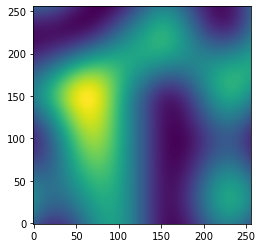

In [9]:
main_grid_size = 256
set_granularity = 3
set_number_unique_vectors = 8

x, y = gen_main_grid(main_grid_size)
granularity, grad_grid_size = gen_grad_grid(main_grid_size, set_granularity)
gvm = generate_gradient_vectors_matrix(set_number_unique_vectors, grad_grid_size)
dm = np.linspace(0, 1, grad_grid_size)

# Calc gradient vectors coordinates for each cell
g_c = np.vectorize(lambda n, s: math.floor(n / s))
gx = np.array(g_c(x, grad_grid_size))
gy = np.array(g_c(y, grad_grid_size))
gc = np.vstack((gx, gy)).T

gradient = [calc_gradient(x[i], y[i], dm, gc[i], gvm) for i in range(main_grid_size ** 2)]
gradient = np.reshape(gradient, [main_grid_size, main_grid_size])

plt.imshow(gradient)
plt.gca().invert_yaxis()
plt.show()

<a id='lets_play'></a>
#### 4. Playing around with the algorithm
The first thing to play around with is the granularity (trying the algorithm with different gradient grid sizes). We can notice how increasing the number of sub grids (and gradient thus number of gradient vectors) and effectively reducing the number of pixels in each gradient grid creates a more textured look.
<p style="text-align: center;"><b>Fig.5:</b>Adding more texture</p>
<img src="increasing_the_subgrid.png" align="center"/>


Another cool thing is to overlay several layers of Perlin noise on top of each other. By doing so we can add fine details to our main texture. First we create a base layer. We then create a number of layers each consecutive uitive one with higher granularity but also with lower amplitude of the output values. We can then sum all layers (flatten them) to get a more detailed texture. In the example below I have increase the granularity by 1 for each layer and have decreased the impact of that layer by $\frac{1}{2^{i}}$ (where $i$ is the level of granularity). 
<p style="text-align: center;"><b>Fig.6:</b>Adding more detail</p>
<img src="adding_details.png" align="center"/>

Finally, we can combine the two effects above and use the apply the algorithm to generate a fine detail terrain map. In the example below I have generated a 1024 by 1014 pixel grid populated with Perlin Noise and colored with matplotlib's terrain color map. The map is computed with a gradient grid of 4 x 4 and 3 additional layers of fine details.
<p style="text-align: center;"><b>Fig.7:</b>Terrain map</p>
<img src="final_map.png" align="center"/>

I think it is pretty cool!

#### 5. Next steps
There are several areas for improvement of the current algorithm, including:
* Refactoring the code to generate also 3D and 4D noise;
* Creating proper octaves of frequency and amplitude;
* Play around with rotating the preselected gradient vectors to create animated 2D noise.